<a href="https://colab.research.google.com/github/ellencarols/Projeto-PIMG-ArUco/blob/main/Projeto_identificadorArUco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando as bibliotecas

In [ ]:
!pip install numpy imageio matplotlib

# Importando as bibliotecas

In [2]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

# DETECÇÃO E ROTAÇÃO

**Detecta região preta do ArUco**

In [3]:
def detect_black_region_boundaries(gray_array):
    black_threshold = 80
    black_mask = (gray_array < black_threshold).astype(np.uint8) * 255
    return black_mask

A função `detect_black_region_boundaries` recebe uma imagem em escala de cinza (`gray_array`) e retorna uma máscara binária. Ela identifica pixels que são 'pretos' (valores menores que `black_threshold`, definido como 80) e os marca como 255 (branco) na máscara, enquanto o restante é 0 (preto). Isso serve para isolar e destacar as regiões mais escuras da imagem, como o marcador ArUco.

**Detecta bordas com Sobel**

In [4]:
def sobel_edge_detection(gray_array):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    height, width = gray_array.shape
    grad_x = np.zeros_like(gray_array, dtype=np.float32)
    grad_y = np.zeros_like(gray_array, dtype=np.float32)

    padded = np.pad(gray_array, ((1, 1), (1, 1)), mode='edge')

    for i in range(height):
        for j in range(width):
            region = padded[i:i+3, j:j+3].astype(np.float32)
            grad_x[i, j] = np.sum(region * sobel_x)
            grad_y[i, j] = np.sum(region * sobel_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)

    return magnitude, None

A função `sobel_edge_detection` implementa o operador de Sobel para detectar bordas em uma imagem em escala de cinza (`gray_array`). Ela define os kernels `sobel_x` e `sobel_y` para calcular os gradientes horizontal e vertical, respectivamente. Em seguida, percorre a imagem aplicando esses kernels para computar `grad_x` e `grad_y`. Finalmente, calcula a `magnitude` das bordas a partir desses gradientes, que representa a intensidade da borda, e a retorna como uma imagem `uint8`.

**Transformada de Hough**

In [5]:
def hough_transform_lines(edge_image, threshold=20, debug=False):
    height, width = edge_image.shape
    diagonal = int(np.sqrt(height**2 + width**2))

    num_thetas = 180
    num_rhos = 2 * diagonal

    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.uint32)

    thetas = np.deg2rad(np.arange(0, 180, 1))
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    edge_points = np.argwhere(edge_image > 100)

    for y, x in edge_points:
        for theta_idx in range(num_thetas):
            rho = int(x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx])
            rho_idx = rho + diagonal
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, theta_idx] += 1

    lines = []
    acc_copy = accumulator.copy()

    for _ in range(20):
        max_val = np.max(acc_copy)
        if max_val < threshold:
            break

        max_idx = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
        rho_idx, theta_idx = max_idx

        rho = rho_idx - diagonal
        theta = thetas[theta_idx]

        lines.append((rho, theta, max_val))

        rho_min = max(0, rho_idx - 10)
        rho_max = min(num_rhos, rho_idx + 10)
        theta_min = max(0, theta_idx - 10)
        theta_max = min(num_thetas, theta_idx + 10)

        acc_copy[rho_min:rho_max, theta_min:theta_max] = 0

    return lines

Esta função `hough_transform_lines` aplica a Transformada de Hough a uma imagem de borda (`edge_image`) para detectar linhas retas. Ela calcula um espaço de Hough (rho x theta), onde cada pixel de borda 'vota' nas linhas possíveis que o atravessam. Em seguida, encontra os picos neste 'acumulador' de votos para identificar as linhas mais proeminentes, retornando uma lista de linhas no formato (rho, theta, votos).

**Filtra linhas principais**

In [6]:
def filter_main_lines(lines, image_shape=None, debug=False):
    horizontal_lines = []
    vertical_lines = []

    for rho, theta, votes in lines:
        theta_deg = np.rad2deg(theta)

        if theta_deg < 20 or theta_deg > 160:
            horizontal_lines.append((rho, theta, votes))

        elif 70 < theta_deg < 110:
            vertical_lines.append((rho, theta, votes))

    horizontal_lines.sort(key=lambda x: x[2], reverse=True)
    vertical_lines.sort(key=lambda x: x[2], reverse=True)

    h_lines = horizontal_lines[:2]
    v_lines = vertical_lines[:2]

    if debug:
        print(f"   Linhas horizontais: {len(h_lines)}")
        print(f"   Linhas verticais: {len(v_lines)}")

    return h_lines, v_lines


A função `filter_main_lines` recebe uma lista de linhas detectadas pela Transformada de Hough e filtra-as para identificar as duas linhas horizontais e as duas linhas verticais mais proeminentes. Essas linhas são prováveis de formar os limites do marcador ArUco, sendo classificadas pela quantidade de votos recebidos na Transformada de Hough.

**Calcula interseção**

In [7]:
def line_intersection(line1, line2):
    rho1, theta1 = line1[0], line1[1]
    rho2, theta2 = line2[0], line2[1]

    a1, b1, c1 = np.cos(theta1), np.sin(theta1), rho1
    a2, b2, c2 = np.cos(theta2), np.sin(theta2), rho2

    det = a1 * b2 - a2 * b1

    if abs(det) < 1e-6:
        return None

    x = (b2 * c1 - b1 * c2) / det
    y = (a1 * c2 - a2 * c1) / det

    return (int(x), int(y))

A função `line_intersection` calcula o ponto de interseção entre duas linhas representadas no formato polar (rho, theta). Ela converte os parâmetros polares para a forma cartesiana das equações de linha (Ax + By = C) e resolve o sistema linear para encontrar as coordenadas (x, y) do ponto onde as linhas se cruzam. Se as linhas forem paralelas (determinante próximo de zero), retorna `None`.

**Encontra cantos**

In [8]:
def find_aruco_corners(h_lines, v_lines, debug=False):
    if len(h_lines) < 2 or len(v_lines) < 2:
        if debug:
            print("Não foi possível detectar 4 linhas principais")
        return None

    corners = []

    for h_line in h_lines:
        for v_line in v_lines:
            intersection = line_intersection(h_line, v_line)
            if intersection is not None:
                corners.append(intersection)

    if len(corners) < 4:
        if debug:
            print(f"Apenas {len(corners)} cantos detectados")
        return None

    corners = np.array(corners)

    corners = corners[corners[:, 1].argsort()]

    top_corners = corners[:2]
    bottom_corners = corners[2:4]

    top_corners = top_corners[top_corners[:, 0].argsort()]
    bottom_corners = bottom_corners[bottom_corners[:, 0].argsort()]

    ordered_corners = np.vstack([
        top_corners[0],
        top_corners[1],
        bottom_corners[1],
        bottom_corners[0]
    ])

    if debug:
        print(f"    4 cantos detectados:")
        print(f"     Top-Left: {ordered_corners[0]}")
        print(f"     Top-Right: {ordered_corners[1]}")
        print(f"     Bottom-Right: {ordered_corners[2]}")
        print(f"     Bottom-Left: {ordered_corners[3]}")

    return ordered_corners


A função `find_aruco_corners` recebe as linhas horizontais (`h_lines`) e verticais (`v_lines`) detectadas. Ela calcula todos os pontos de interseção entre essas linhas. Se forem encontrados pelo menos 4 cantos, ela os organiza para formar o contorno do marcador ArUco, geralmente na ordem superior-esquerdo, superior-direito, inferior-direito e inferior-esquerdo, retornando-os como um array NumPy. Caso contrário, retorna `None`. O parâmetro `debug` permite imprimir informações sobre o processo de detecção e os cantos encontrados.

In [9]:
def detect_text_position(gray_array, corners, debug=False):

    if corners is None:
        return None

    height, width = gray_array.shape

    # Centro do ArUco
    center_x = int(np.mean(corners[:, 0]))
    center_y = int(np.mean(corners[:, 1]))

    # Dimensões do ArUco
    aruco_width = int(np.max(corners[:, 0]) - np.min(corners[:, 0]))
    aruco_height = int(np.max(corners[:, 1]) - np.min(corners[:, 1]))

    # Threshold para detectar texto (pixels escuros)
    text_threshold = 180

    # Definir regiões para buscar texto
    margin = 20

    # Região ACIMA do ArUco
    y_above_start = max(0, int(np.min(corners[:, 1])) - aruco_height - margin)
    y_above_end = max(0, int(np.min(corners[:, 1])) - margin)
    region_above = gray_array[y_above_start:y_above_end, :]

    # Região ABAIXO do ArUco
    y_below_start = min(height, int(np.max(corners[:, 1])) + margin)
    y_below_end = min(height, int(np.max(corners[:, 1])) + aruco_height + margin)
    region_below = gray_array[y_below_start:y_below_end, :]

    # Região À ESQUERDA do ArUco
    x_left_start = max(0, int(np.min(corners[:, 0])) - aruco_width - margin)
    x_left_end = max(0, int(np.min(corners[:, 0])) - margin)
    region_left = gray_array[:, x_left_start:x_left_end]

    # Região À DIREITA do ArUco
    x_right_start = min(width, int(np.max(corners[:, 0])) + margin)
    x_right_end = min(width, int(np.max(corners[:, 0])) + aruco_width + margin)
    region_right = gray_array[:, x_right_start:x_right_end]

    def count_text_pixels(region):
        if region.size == 0:
            return 0
        return np.sum(region < text_threshold)

    text_above = count_text_pixels(region_above)
    text_below = count_text_pixels(region_below)
    text_left = count_text_pixels(region_left)
    text_right = count_text_pixels(region_right)

    if debug:
        print(f"   Texto detectado:")
        print(f"     Acima: {text_above} pixels")
        print(f"     Abaixo: {text_below} pixels")
        print(f"     Esquerda: {text_left} pixels")
        print(f"     Direita: {text_right} pixels")

    # Determinar posição dominante do texto
    max_text = max(text_above, text_below, text_left, text_right)

    if max_text < 100:
        if debug:
            print(f"   Texto insuficiente detectado")
        return None

    if text_above == max_text:
        return 'above'
    elif text_below == max_text:
        return 'below'
    elif text_left == max_text:
        return 'left'
    elif text_right == max_text:
        return 'right'

    return None

A função `detect_text_position` recebe uma imagem em escala de cinza (`gray_array`) e os cantos detectados do ArUco (`corners`). Ela calcula o centro e as dimensões do ArUco, e então define quatro regiões de busca (acima, abaixo, à esquerda e à direita do ArUco) para encontrar pixels escuros que representam texto. Conta os pixels de texto em cada região e retorna a posição (e.g., 'above', 'below') onde o texto é mais proeminente. Se nenhum texto significativo for encontrado, retorna `None`.

**Calcula rotação necessaria baseada na posição do texto**

In [10]:
def calculate_rotation_from_text_position(text_pos, debug=False):
    if text_pos is None:
        if debug:
            print("   Texto não detectado, sem rotação")
        return 0

    if debug:
        print(f"   Texto detectado: {text_pos}")

    # Mapear posição do texto para rotação necessária
    rotation_map = {
        'below': 0,      # Texto abaixo = CORRETO, sem rotação
        'above': 180,    # Texto acima = inverter 180°
        'left': -90,     # Texto à esquerda = rotacionar 90° horário
        'right': 90,     # Texto à direita = rotacionar 90° anti-horário
    }

    rotation = rotation_map.get(text_pos, 0)

    if debug:
        if rotation == 0:
            print(f"   Texto já está ABAIXO (correto), rotação: 0°")
        else:
            print(f"    Rotação necessária: {rotation}°")

    return rotation

A função `calculate_rotation_from_text_position` recebe a posição detectada do texto (`text_pos`) em relação ao marcador ArUco e, com base em uma regra predefinida (texto deve ficar ABAIXO do ArUco), calcula o ângulo de rotação necessário para orientar corretamente a imagem. Por exemplo, se o texto estiver 'above', a imagem deve ser rotacionada em 180 graus.

**Rotaciona Imagem**

In [11]:
def rotate_image(img_array, angle_deg):
    if abs(angle_deg) < 0.5:
        return img_array

    height, width = img_array.shape[:2]
    center_x, center_y = width // 2, height // 2

    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    if len(img_array.shape) == 3:
        rotated = np.ones_like(img_array) * 255
    else:
        rotated = np.ones_like(img_array) * 255

    for y in range(height):
        for x in range(width):
            rel_x = x - center_x
            rel_y = y - center_y

            src_x = int(rel_x * cos_a + rel_y * sin_a + center_x)
            src_y = int(-rel_x * sin_a + rel_y * cos_a + center_y)

            if 0 <= src_x < width and 0 <= src_y < height:
                rotated[y, x] = img_array[src_y, src_x]

    return rotated


A função `rotate_image` rotaciona uma imagem por um ângulo especificado em graus. Ela realiza uma transformação pixel a pixel, calculando as coordenadas de origem de cada pixel na imagem rotacionada com base na rotação inversa. Pixels fora dos limites da imagem original são preenchidos com branco. Se o ângulo de rotação for insignificante (próximo de zero), a imagem original é retornada sem modificações.

# REMOÇÃO DE TEXTO

**Detecta região do ArUco para preservação**

In [12]:
def detect_aruco_region(gray_array):
    height, width = gray_array.shape

    threshold = 150
    binary = (gray_array < threshold).astype(np.uint8)

    col_sums = np.sum(binary, axis=0)
    row_sums = np.sum(binary, axis=1)

    col_threshold = height * 0.05
    row_threshold = width * 0.05

    significant_cols = np.where(col_sums > col_threshold)[0]
    significant_rows = np.where(row_sums > row_threshold)[0]

    if len(significant_cols) == 0 or len(significant_rows) == 0:
        margin = min(width, height) // 4
        return (width//2 - margin, height//2 - margin,
                width//2 + margin, height//2 + margin)

    col_groups = []
    current_group = [significant_cols[0]]
    for i in range(1, len(significant_cols)):
        if significant_cols[i] - significant_cols[i-1] <= 5:
            current_group.append(significant_cols[i])
        else:
            col_groups.append(current_group)
            current_group = [significant_cols[i]]
    col_groups.append(current_group)

    largest_col_group = max(col_groups, key=len)
    x_min = max(0, largest_col_group[0] - 10)
    x_max = min(width, largest_col_group[-1] + 10)

    row_groups = []
    current_group = [significant_rows[0]]
    for i in range(1, len(significant_rows)):
        if significant_rows[i] - significant_rows[i-1] <= 5:
            current_group.append(significant_rows[i])
        else:
            row_groups.append(current_group)
            current_group = [significant_rows[i]]
    row_groups.append(current_group)

    largest_row_group = max(row_groups, key=len)
    y_min = max(0, largest_row_group[0] - 10)
    y_max = min(height, largest_row_group[-1] + 10)

    return (x_min, y_min, x_max, y_max)

A função `detect_aruco_region` tem como objetivo encontrar a caixa delimitadora do marcador ArUco dentro de uma imagem em escala de cinza. Ela binariza a imagem, calcula as somas de linhas e colunas de pixels escuros, e então identifica grupos contíguos de somas significativas para estimar os intervalos x e y do marcador. Essa função é usada para auxiliar na remoção de texto, delimitando a área do ArUco a ser preservada.

**Remove texto, preserva ArUco**

In [13]:
def remove_text_preserve_aruco(img_array):
    height, width = img_array.shape[0], img_array.shape[1]

    gray = np.dot(img_array[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

    aruco_x_min, aruco_y_min, aruco_x_max, aruco_y_max = detect_aruco_region(gray)

    result = np.ones_like(img_array) * 255

    result[aruco_y_min:aruco_y_max, aruco_x_min:aruco_x_max] = \
        img_array[aruco_y_min:aruco_y_max, aruco_x_min:aruco_x_max]

    return result

A função `remove_text_preserve_aruco` recebe uma imagem RGB (`img_array`) e tem como objetivo remover todo o texto e elementos externos, preservando apenas o marcador ArUco. Ela primeiro converte a imagem para escala de cinza, utiliza a função `detect_aruco_region` para encontrar a caixa delimitadora do ArUco e, em seguida, cria uma nova imagem preenchida com branco. Por fim, copia apenas a região do ArUco da imagem original para a nova imagem, isolando efetivamente o marcador.

# PIPELINE COMPLETO

Validação: palavra abaixo do Aruco

In [14]:
def process_aruco_complete(input_path, debug=True):

    # Carregar imagem
    if debug:
        print("Carregando imagem...")
    img_array = iio.imread(input_path)

    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    if debug:
        print(f"  Dimensões: {img_array.shape[1]}x{img_array.shape[0]}px")
        print()

    # Converter para cinza
    if debug:
        print(" Convertendo para escala de cinza...")
    gray = np.dot(img_array[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    print()

    # Detectar região preta
    if debug:
        print(" Detectando região preta do ArUco...")
    black_mask = detect_black_region_boundaries(gray)
    print()

    # Detectar bordas
    if debug:
        print(" Detectando bordas...")
    edges, _ = sobel_edge_detection(black_mask)
    print()

    # Hough
    if debug:
        print(" Transformada de Hough...")
    lines = hough_transform_lines(edges, threshold=20)
    print()

    # Filtrar linhas
    if debug:
        print(" Filtrando linhas principais...")
    h_lines, v_lines = filter_main_lines(lines)
    print()

    # Cantos
    if debug:
        print(" Encontrando cantos do ArUco...")
    corners = find_aruco_corners(h_lines, v_lines)

    if corners is None:
        if debug:
            print("FALHA: Não foi possível detectar ArUco")
        return None, None

    if debug:
        print(f" 4 cantos detectados")
        print()

    # Detectar posição do texto
    if debug:
        print(" Detectando posição do texto...")
    text_position = detect_text_position(gray, corners, debug=debug)
    print()

    # Calcular rotação baseado na posição do texto
    if debug:
        print(" Calculando rotação necessária...")
    rotation_angle = calculate_rotation_from_text_position(text_position, debug=debug)
    print()

    # Rotacionar
    if rotation_angle != 0:
        if debug:
            print(f" Rotacionando imagem {rotation_angle}°...")
        rotated_img = rotate_image(img_array, rotation_angle)
        if debug:
            print(" Imagem rotacionada")
            print()
    else:
        if debug:
            print(" Imagem já está na orientação correta")
            print()
        rotated_img = img_array

    # Remover Texto
    if debug:
        print(" Texto removido.")
    final_img = remove_text_preserve_aruco(rotated_img)
    if debug:
        print()

    if debug:
        print(f" Concluído!")
        if rotation_angle != 0:
            print(f"  Rotação aplicada: {rotation_angle}°")
        else:
            print(f"  Sem rotação necessária")

    return rotated_img, final_img

A função `process_aruco_complete` orquestra o pipeline completo de processamento de imagens para detecção, orientação e remoção de texto em torno de marcadores ArUco. Ela executa uma sequência de etapas:
1.  **Carregamento e Pré-processamento:** Carrega a imagem e a converte para escala de cinza.
2.  **Detecção de Cantos e Linhas:** Utiliza `detect_black_region_boundaries`, `sobel_edge_detection`, `hough_transform_lines` e `filter_main_lines` para encontrar as linhas e cantos do ArUco, focando na região preta para ignorar bordas cinzas.
3.  **Detecção de Orientação:** Emprega `detect_text_position` para identificar a posição do texto em relação ao ArUco e `calculate_rotation_from_text_position` para determinar o ângulo de rotação necessário.
4.  **Rotação da Imagem:** Aplica a rotação calculada à imagem usando `rotate_image`.
5.  **Remoção de Texto e Limpeza Final:** Por fim, utiliza `remove_text_preserve_aruco` para remover o texto e elementos externos da imagem rotacionada, isolando o ArUco principal. Retorna a imagem rotacionada (para validação) e a imagem final sem texto.

**Execução**

Carregando imagem...
  Dimensões: 640x640px

 Convertendo para escala de cinza...

 Detectando região preta do ArUco...

 Detectando bordas...

 Transformada de Hough...

 Filtrando linhas principais...

 Encontrando cantos do ArUco...
 4 cantos detectados

 Detectando posição do texto...
   Texto detectado:
     Acima: 278 pixels
     Abaixo: 0 pixels
     Esquerda: 0 pixels
     Direita: 7472 pixels

 Calculando rotação necessária...
   Texto detectado: right
    Rotação necessária: 90°

 Rotacionando imagem 90°...
 Imagem rotacionada

 Texto removido.

 Concluído!
  Rotação aplicada: 90°



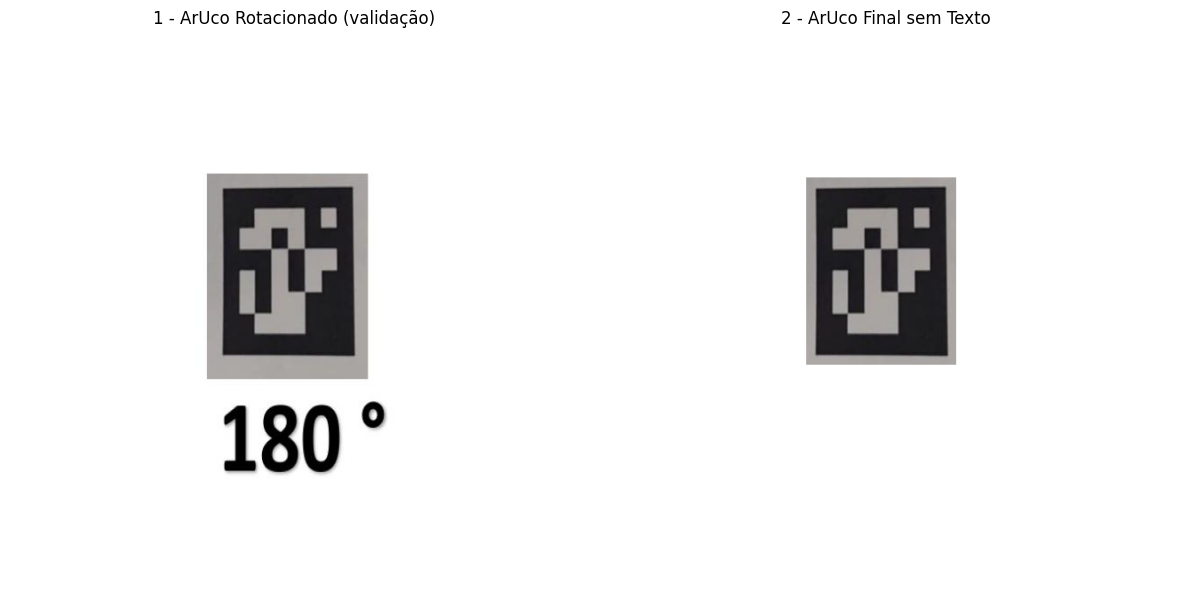

In [15]:
input_image = "../data/imagem7.jpg"

# Processar
rotated, final = process_aruco_complete(
    input_image,
    debug=True
)

# Validação
if rotated is not None and final is not None:
    print()
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(rotated)
    plt.title("1 - ArUco Rotacionado (validação)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final)
    plt.title("2 - ArUco Final sem Texto")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Este bloco de código executa o pipeline completo de processamento de ArUco usando a função `process_aruco_complete` na imagem especificada  Ele passa o modo de depuração ativado (`debug=True`) para acompanhar o processo. Após o processamento, se as imagens rotacionada e final forem geradas com sucesso, ele as exibe lado a lado usando `matplotlib` para validação visual da orientação e da remoção do texto.

**PROCESSAMENTO DE IMAGEM**

In [16]:
def binarize_image(gray_array, threshold=127):
    binary = np.where(gray_array < threshold, 0, 255).astype(np.uint8)
    return binary

A função `binarize_image` converte uma imagem em escala de cinza (`gray_array`) em uma imagem binária. Pixels com valores abaixo do `threshold` especificado são definidos como 0 (preto), e pixels com valores iguais ou acima do threshold são definidos como 255 (branco).

In [17]:
def detect_black_edges_and_mask(gray_array, debug=False):
    height, width = gray_array.shape

    # Threshold mais agressivo: apenas pixels MUITO escuros (pretos)
    # Cinza típico: 100-180, Preto do ArUco: < 80
    black_threshold = 80
    black_mask = (gray_array < black_threshold).astype(np.uint8) * 255

    if debug:
        print(f"   Threshold para preto: {black_threshold}")
        print(f"   Pixels pretos detectados: {np.sum(black_mask == 255)}")

    # Detectar bordas APENAS na região preta
    edges, _ = sobel_edge_detection(black_mask)

    return edges, black_mask

A função `detect_black_region_boundaries` tem como objetivo detectar as bordas da região *preta* de um marcador ArUco. Ela aplica um `black_threshold` agressivo (80) para isolar apenas os pixels muito escuros, ignorando quaisquer bordas cinzas. Em seguida, aplica a detecção de bordas de Sobel (`sobel_edge_detection`) apenas nesta máscara preta para obter bordas mais precisas do centro do ArUco. Retorna as bordas detectadas e a máscara preta.

# VISUALIZAÇÃO

**Desenha o resultado da detecção na imagem**

In [18]:
def draw_detection_result(img_array, corners):
    result = img_array.copy()

    if corners is None or len(corners) != 4:
        return result

    # Garantir array inteiro
    corners = np.array(corners, dtype=int)

    # Desenhar linhas conectando os cantos
    for i in range(4):
        x1, y1 = corners[i]
        x2, y2 = corners[(i + 1) % 4]

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy

        x, y = x1, y1

        while True:
            if 0 <= x < result.shape[1] and 0 <= y < result.shape[0]:
                # Linha verde
                for dy_offset in [-1, 0, 1]:
                    for dx_offset in [-1, 0, 1]:
                        ny, nx = y + dy_offset, x + dx_offset
                        if 0 <= nx < result.shape[1] and 0 <= ny < result.shape[0]:
                            result[ny, nx] = [0, 255, 0]

            if x == x2 and y == y2:
                break

            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x += sx
            if e2 < dx:
                err += dx
                y += sy

    # Desenhar cantos (círculos vermelhos)
    for cx, cy in corners:
        radius = 5
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                if dx*dx + dy*dy <= radius*radius:
                    ny, nx = cy + dy, cx + dx
                    if 0 <= nx < result.shape[1] and 0 <= ny < result.shape[0]:
                        result[ny, nx] = [255, 0, 0]

    return result


A função `draw_detection_result` visualiza o resultado da detecção desenhando as linhas que conectam os cantos e marcando os cantos como círculos. Ela recebe a imagem original (`img_array`) e os `corners` detectados. Se os cantos forem válidos (4 cantos), ela desenha linhas verdes grossas conectando-os e círculos vermelhos nos próprios cantos, retornando uma cópia da imagem com essas marcações.

In [19]:
def detect_aruco_black_only(img_array, debug=True):
    if debug:
        print("DETECÇÃO DE ARUCO - Localinado na Região PRETA")
        print()

    # Garantir 3 canais
    if img_array.ndim == 2:
        img_array = np.stack([img_array]*3, axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    height, width = img_array.shape[:2]

    if debug:
        print("1. Imagem recebida em memória")
        print(f"   Dimensões: {width}x{height}px")
        print()

    # Converter para escala de cinza
    if debug:
        print("2. Convertendo para escala de cinza...")
    gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    print()

    # Detectar apenas região preta
    if debug:
        print("3. Detectando região PRETA (threshold < 80)...")
    edges, black_mask = detect_black_edges_and_mask(gray, debug=debug)
    print()

    # Transformada de Hough
    if debug:
        print("4. Aplicando Transformada de Hough...")
    lines = hough_transform_lines(edges, threshold=20, debug=debug)
    print()

    # Filtrar linhas
    if debug:
        print("5. Filtrando linhas principais...")
    h_lines, v_lines = filter_main_lines(lines, (height, width), debug=debug)
    print()

    # Encontrar cantos
    if debug:
        print("6. Calculando interseções (cantos do ArUco)...")
    corners = find_aruco_corners(h_lines, v_lines, debug=debug)
    print()

    if debug:
        if corners is not None:
            print("ArUco PRETO localizado!")
        else:
            print("FALHA NA DETECÇÃO")

    return corners, edges, black_mask


A função `detect_aruco_black_only` fornece um pipeline focado para detectar a região preta de um marcador ArUco, especificamente ignorando a borda cinza externa. Ela processa a imagem através de conversão para escala de cinza, black_region_boundaries para identificar a região preta, detecção de bordas, Transformada de Hough, filtragem de linhas e, finalmente, identificação de cantos. Ela retorna os cantos detectados junto com as imagens intermediárias de borda e máscara preta.

# Execução

DETECÇÃO DE ARUCO - Localinado na Região PRETA

1. Imagem recebida em memória
   Dimensões: 640x640px

2. Convertendo para escala de cinza...

3. Detectando região PRETA (threshold < 80)...
   Threshold para preto: 80
   Pixels pretos detectados: 19040

4. Aplicando Transformada de Hough...

5. Filtrando linhas principais...
   Linhas horizontais: 2
   Linhas verticais: 2

6. Calculando interseções (cantos do ArUco)...
    4 cantos detectados:
     Top-Left: [240 176]
     Top-Right: [384 174]
     Bottom-Right: [387 365]
     Bottom-Left: [240 365]

ArUco PRETO localizado!

DETECÇÃO DO ArUco (REGIÃO PRETA)
Número de cantos detectados: 4


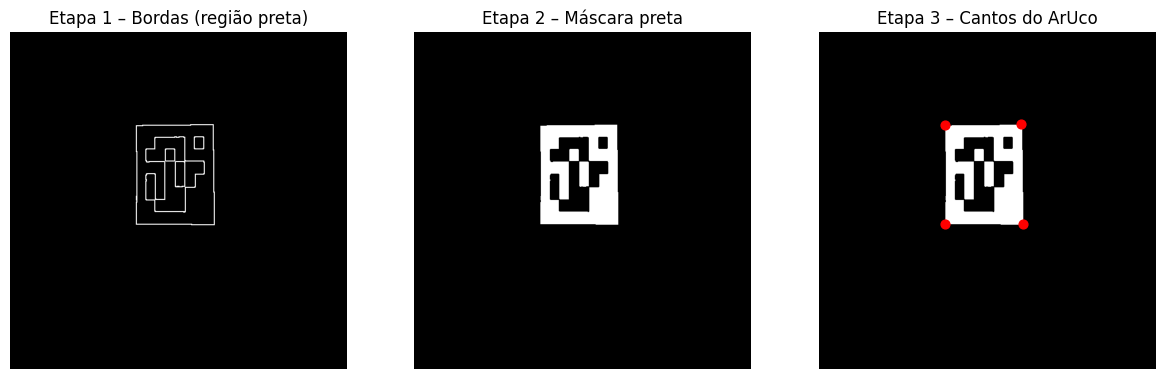

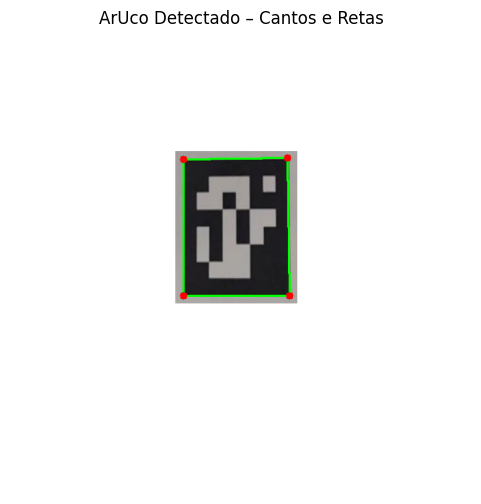

<Figure size 640x480 with 0 Axes>

In [20]:
# Verificação de segurança
if final is None:
    raise ValueError("A variável 'final' não existe. Execute a célula anterior primeiro.")

# Executar detecção usando a imagem FINAL em memória
corners, edges, black_mask = detect_aruco_black_only(
    final,
    debug=True
)

# Validação
if corners is not None:
    print()
    print("DETECÇÃO DO ArUco (REGIÃO PRETA)")
    print(f"Número de cantos detectados: {len(corners)}")

    plt.figure(figsize=(20, 5))

    # Etapa 1 – Bordas
    plt.subplot(1, 4, 1)
    plt.imshow(edges, cmap="gray")
    plt.title("Etapa 1 – Bordas (região preta)")
    plt.axis("off")

    # Etapa 2 – Máscara preta
    plt.subplot(1, 4, 2)
    plt.imshow(black_mask, cmap="gray")
    plt.title("Etapa 2 – Máscara preta")
    plt.axis("off")

    # Etapa 3 – Cantos detectados sobre a máscara
    plt.subplot(1, 4, 3)
    plt.imshow(black_mask, cmap="gray")
    plt.scatter(corners[:, 0], corners[:, 1], c="red", s=40)
    plt.title("Etapa 3 – Cantos do ArUco")
    plt.axis("off")

    # Etapa 4 – ArUco detectado (equivalente ao aruco_detectado_preto.png)
    resultado_final = draw_detection_result(final, corners)

    plt.figure(figsize=(6, 6))
    plt.imshow(resultado_final)
    plt.title("ArUco Detectado – Cantos e Retas")
    plt.axis("off")
    plt.show()
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum ArUco foi detectado.")